In [368]:
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
#https://pyramid-arima.readthedocs.io/en/latest/_submodules/arima.html
import numpy
from numpy import newaxis
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pyramid.arima import auto_arima

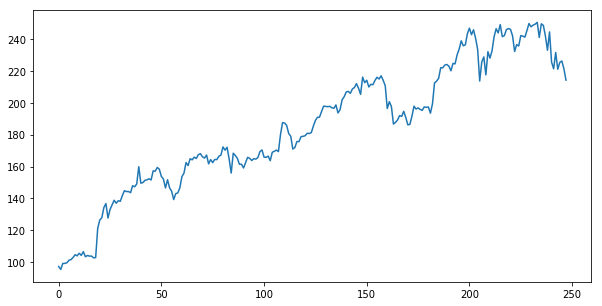

In [369]:
dataset = pandas.read_csv('HistoricalQuotes.csv', usecols=[1], engine='python', skipfooter=3)
dataset = numpy.flipud(dataset)[1::]
plt.figure(figsize=(10,5))
plt.plot(dataset)
plt.show()

In [370]:
# fix random seed for reproducibility
#numpy.random.seed(7)

In [371]:
# load the dataset
dataset = pandas.read_csv('HistoricalQuotes.csv', usecols=[1], engine='python', skipfooter=3)
dataset = numpy.flipud(dataset)[1::]
#dataset = dataframe.values
dataset = dataset.astype('float32')

In [372]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [373]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

166 82


In [374]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [375]:
# reshape into X=t and Y=t+1
look_back = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [376]:
trainX.shape

(150, 15)

In [377]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [378]:
trainX.shape

(150, 1, 15)

In [379]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(64, input_shape=(1, look_back)))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=2)

Epoch 1/200
 - 3s - loss: 0.0254
Epoch 2/200
 - 1s - loss: 0.0077
Epoch 3/200
 - 1s - loss: 0.0057
Epoch 4/200
 - 1s - loss: 0.0052
Epoch 5/200
 - 1s - loss: 0.0059
Epoch 6/200
 - 1s - loss: 0.0052
Epoch 7/200
 - 1s - loss: 0.0049
Epoch 8/200
 - 0s - loss: 0.0055
Epoch 9/200
 - 0s - loss: 0.0049
Epoch 10/200
 - 1s - loss: 0.0046
Epoch 11/200
 - 0s - loss: 0.0044
Epoch 12/200
 - 0s - loss: 0.0039
Epoch 13/200
 - 0s - loss: 0.0036
Epoch 14/200
 - 0s - loss: 0.0042
Epoch 15/200
 - 1s - loss: 0.0033
Epoch 16/200
 - 0s - loss: 0.0034
Epoch 17/200
 - 0s - loss: 0.0031
Epoch 18/200
 - 0s - loss: 0.0031
Epoch 19/200
 - 1s - loss: 0.0039
Epoch 20/200
 - 0s - loss: 0.0033
Epoch 21/200
 - 0s - loss: 0.0034
Epoch 22/200
 - 1s - loss: 0.0030
Epoch 23/200
 - 1s - loss: 0.0023
Epoch 24/200
 - 0s - loss: 0.0035
Epoch 25/200
 - 0s - loss: 0.0032
Epoch 26/200
 - 1s - loss: 0.0037
Epoch 27/200
 - 1s - loss: 0.0032
Epoch 28/200
 - 0s - loss: 0.0027
Epoch 29/200
 - 0s - loss: 0.0025
Epoch 30/200
 - 0s - lo

In [380]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 4.41 RMSE
Test Score: 10.16 RMSE


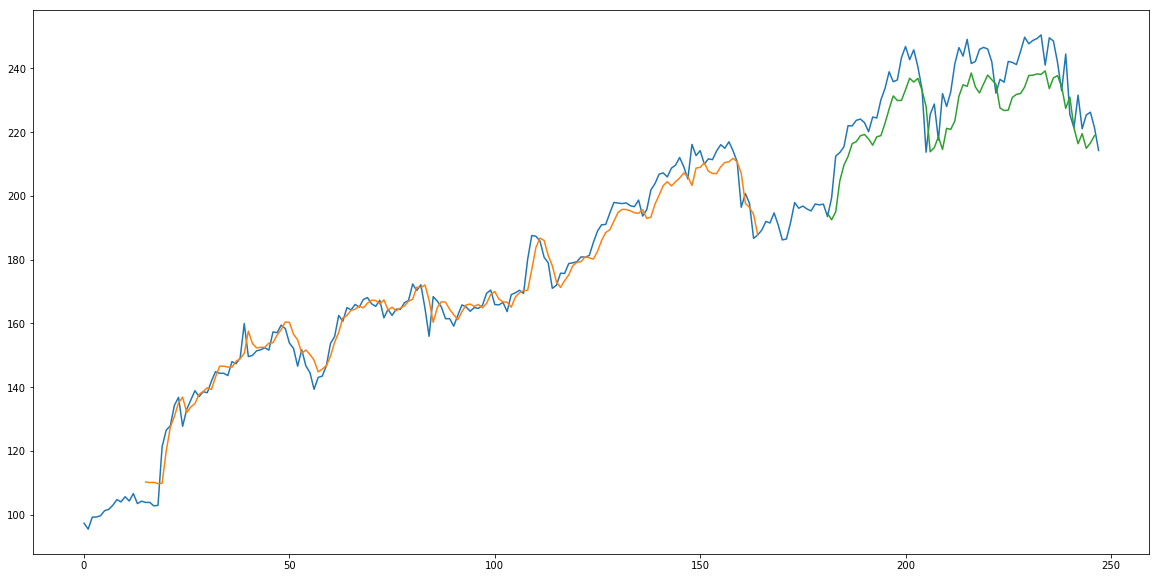

In [381]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [382]:
train2 = dataset
trainX2, trainY2 = create_dataset(train2, look_back)
trainX2 = numpy.reshape(trainX2, (trainX2.shape[0], 1, trainX2.shape[1]))
trainX2.shape, trainY2.shape

((232, 1, 15), (232,))

In [383]:
model2 = Sequential()
model2.add(LSTM(64, input_shape=(1, look_back)))
model2.add(Dropout(0.3))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')
model2.fit(trainX2, trainY2, epochs=200, batch_size=1, verbose=2)

Epoch 1/200
 - 3s - loss: 0.0253
Epoch 2/200
 - 1s - loss: 0.0092
Epoch 3/200
 - 1s - loss: 0.0089
Epoch 4/200
 - 1s - loss: 0.0077
Epoch 5/200
 - 1s - loss: 0.0065
Epoch 6/200
 - 1s - loss: 0.0065
Epoch 7/200
 - 1s - loss: 0.0062
Epoch 8/200
 - 1s - loss: 0.0048
Epoch 9/200
 - 1s - loss: 0.0053
Epoch 10/200
 - 1s - loss: 0.0053
Epoch 11/200
 - 1s - loss: 0.0058
Epoch 12/200
 - 1s - loss: 0.0057
Epoch 13/200
 - 1s - loss: 0.0063
Epoch 14/200
 - 1s - loss: 0.0048
Epoch 15/200
 - 1s - loss: 0.0052
Epoch 16/200
 - 1s - loss: 0.0055
Epoch 17/200
 - 1s - loss: 0.0036
Epoch 18/200
 - 1s - loss: 0.0044
Epoch 19/200
 - 1s - loss: 0.0056
Epoch 20/200
 - 1s - loss: 0.0042
Epoch 21/200
 - 1s - loss: 0.0038
Epoch 22/200
 - 1s - loss: 0.0038
Epoch 23/200
 - 1s - loss: 0.0048
Epoch 24/200
 - 1s - loss: 0.0034
Epoch 25/200
 - 1s - loss: 0.0034
Epoch 26/200
 - 1s - loss: 0.0035
Epoch 27/200
 - 1s - loss: 0.0048
Epoch 28/200
 - 1s - loss: 0.0039
Epoch 29/200
 - 1s - loss: 0.0036
Epoch 30/200
 - 1s - lo

In [384]:
# make predictions
trainPredict2 = model2.predict(trainX2)
# invert predictions
trainPredict2 = scaler.inverse_transform(trainPredict2)
trainY2 = scaler.inverse_transform([trainY2])
# calculate root mean squared error
trainScore2 = math.sqrt(mean_squared_error(trainY2, trainPredict2.T))
print('Train Score2: %.2f RMSE' % (trainScore2))

Train Score2: 4.82 RMSE


In [385]:
trainY2.shape, trainPredict2.shape

((1, 232), (232, 1))

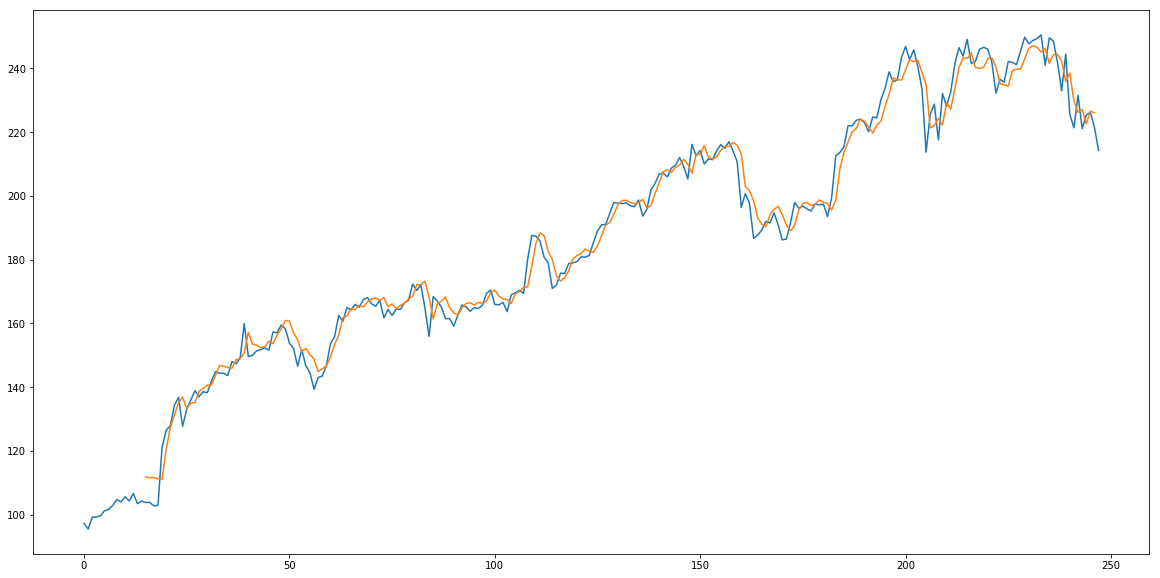

In [386]:
# shift train predictions for plotting
trainPredictPlot2 = numpy.empty_like(dataset)
trainPredictPlot2[:, :] = numpy.nan
trainPredictPlot2[look_back:len(trainPredict2)+look_back, :] = trainPredict2

# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot2)
plt.show()

In [387]:
import pandas as pd
#from plotly.plotly import plot_mpl
#from statsmodels.tsa.seasonal import seasonal_decompose

In [388]:
#trainPredict2 = pd.DataFrame(trainPredict2)
#result = seasonal_decompose(trainPredict2, model='multiplicative')
#fig = result.plot()
#plot_mpl(fig)

In [389]:
numpy.savetxt("LSTM_Predicted.csv", trainPredict2, delimiter=",")

In [390]:
stepwise_model = auto_arima(trainPredict2, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1141.226, BIC=1158.459, Fit time=1.213 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1213.718, BIC=1227.505, Fit time=0.233 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1145.185, BIC=1158.972, Fit time=0.836 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1141.436, BIC=1162.117, Fit time=1.413 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1281.108, BIC=1294.895, Fit time=0.205 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=1143.079, BIC=1163.759, Fit time=2.115 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=1143.534, BIC=1167.661, Fit time=2.585 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=1

In [391]:
print(stepwise_model.aic())

1138.91996203


In [392]:
n_periods = 30
future_forecast = stepwise_model.predict(n_periods=n_periods)
print(future_forecast)
trainPredict2full = numpy.append(trainPredict2,future_forecast)

[ 227.56701373  226.47597833  226.4219464   226.87145344  227.00991981
  227.27876055  226.58909822  227.01345923  226.04211396  225.8629802
  226.40440324  226.51474013  226.78044196  226.0524204   226.44648338
  225.43939596  225.22834024  225.73720649  225.81597484  226.04983598
  225.29010565  225.65234083  224.61344293  224.37054983  224.84758793
  224.89452504  225.09655856  224.30500011  224.63540785  223.56468222]


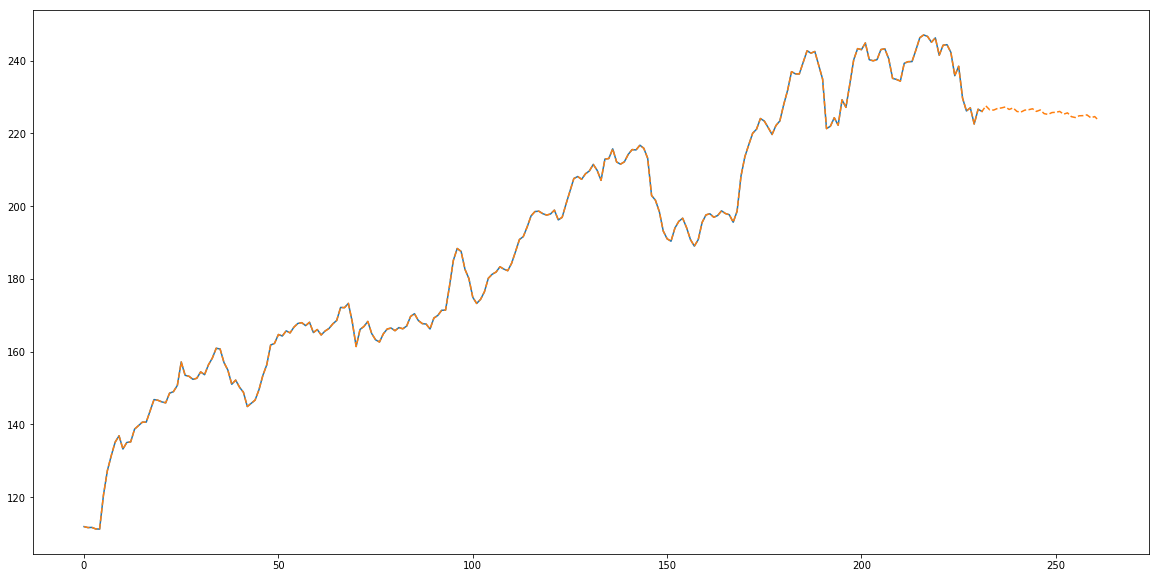

In [393]:
plt.figure(figsize=(20,10))
plt.plot(trainPredict2)
plt.plot(trainPredict2full, '--')
plt.show()